In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat  
import pyedflib  
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import mne
import pandas as pd
import random
import tqdm as tqdm


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/jessy/Library/Application Support/hatch/env/virtual/eggs/iFABgFmj/eggs/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/jessy/Library/Application Support/hatch/env/virtual/eggs/iFABgFmj/eggs/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/jessy/Library/Applicati

In [2]:
class PhysioNetDataset(Dataset):

    def __init__(self, input_folder, max_rows=259520, num_samples_to_load=320):

        self.input_folder = input_folder
        self.file_list = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f)) and f.endswith('.csv')]
        self.max_rows = max_rows
        self.batches = []
        self.labels = []
        self.num_samples_to_load = num_samples_to_load
        # Appeler la fonction pour charger et randomiser les données
        self.randomize_data()

    def randomize_data(self):

        len_packets = (self.num_samples_to_load//3) + 1
        len_packet = 160 #1secondes
        num_files_total = 109 #Nb de sujets

        for e in tqdm.tqdm( range(len_packets) ):

            file_name = self.file_list[np.random.randint(0, num_files_total )]
            file_path = os.path.join(self.input_folder, file_name)

            df = pd.read_csv(file_path).head(self.max_rows)

            # 3 label au total, on stock 3 labels par sujet aleatoirement parmis les experiences
            
            for label_i in range(3):  # 3 labels dans ce cas (0, 1, 2)
                df_label = df[df['label'] == label_i]

                if len(df_label) >= len_packet:
                    # Nous voulons 160 échantillons dans chaque batch
                    random_samples = df_label.sample(n=len_packet, random_state=42)

                    samples = random_samples.drop(columns=['label']).to_numpy()

                    # Ajouter le batch à la liste de batches
                    self.batches.append(samples)  # Chaque `samples` a la forme (160, features)
                    self.labels.extend([label_i] * len_packet)  # Ajouter le label correspondant pour chaque échantillon

                else:
                    print(f"Pas assez d'échantillons pour le label {label_i} (trouvés : {len(df_label)})")



    def __len__(self):
        # Retourne le nombre total d'échantillons
        return len(self.batches)

    def __getitem__(self, idx):
        # Retourne un échantillon et son label basé sur l'index
        batch = torch.tensor(self.batches[idx], dtype=torch.float32)  # Convertir en tensor PyTorch
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Convertir en tensor PyTorch
        return batch, label

In [3]:
dataset = PhysioNetDataset(input_folder='./datasources/physionet-extracted/', num_samples_to_load=1500)

#
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



for batch_idx, (inputs, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx}: Inputs shape {inputs.shape}, Labels shape {labels.shape}")
    if batch_idx >= 5: 
        break

100%|██████████| 501/501 [02:54<00:00,  2.87it/s]

Batch 0: Inputs shape torch.Size([32, 160, 8]), Labels shape torch.Size([32])
Batch 1: Inputs shape torch.Size([32, 160, 8]), Labels shape torch.Size([32])
Batch 2: Inputs shape torch.Size([32, 160, 8]), Labels shape torch.Size([32])
Batch 3: Inputs shape torch.Size([32, 160, 8]), Labels shape torch.Size([32])
Batch 4: Inputs shape torch.Size([32, 160, 8]), Labels shape torch.Size([32])
Batch 5: Inputs shape torch.Size([32, 160, 8]), Labels shape torch.Size([32])


In [10]:
import matplotlib.pyplot as plt

Batch 0: Inputs shape torch.Size([32, 160, 8]), Labels shape torch.Size([32])


RuntimeError: Numpy is not available

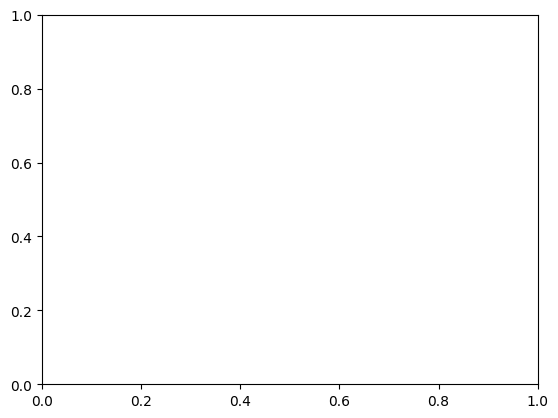

In [15]:
for batch_idx, (inputs, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx}: Inputs shape {inputs.shape}, Labels shape {labels.shape}")
    plt.figure()
    plt.plot(inputs.cpu().detach())
    if batch_idx >= 5: 
        break

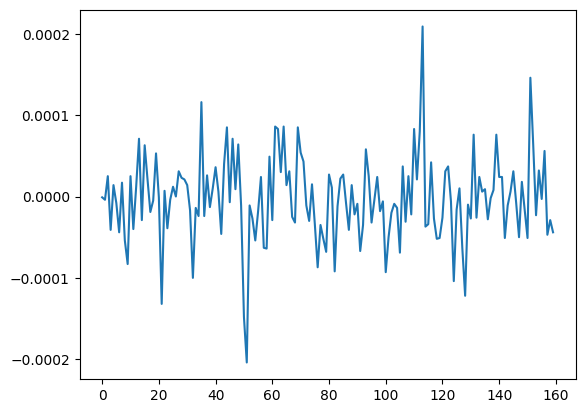

In [53]:
plt.plot(inputs[5,:,1].tolist())

In [54]:
labels

tensor([0, 2, 2, 1, 2, 2, 1, 0, 0, 2, 0, 1, 0, 2, 0, 2, 1, 2, 2, 2, 0, 0, 0, 1,
        2, 2, 0, 0, 1, 0, 0, 1])

In [56]:
inputs.shape[0]

32

In [30]:
np.array([])

array([], dtype=float64)

In [8]:
len(dataset)

1503

In [5]:
df = pd.read_csv('./datasources/physionet-extracted/sujet_1.csv')

In [6]:
df['group'] = (df['label'] != df['label'].shift()).cumsum()

In [7]:
df

,Fc1.,Fc2.,C3..,Cz..,C4..,Cp1.,Pz..,Poz.,label,group
0,-0.000098,-0.000106,-0.000078,-0.000093,-0.000103,-0.000083,-0.000099,-0.000077,1,1
1,-0.000102,-0.000105,-0.000090,-0.000115,-0.000097,-0.000102,-0.000090,-0.000062,1,1
2,-0.000069,-0.000076,-0.000063,-0.000085,-0.000064,-0.000073,-0.000065,-0.000041,1,1
3,-0.000060,-0.000067,-0.000046,-0.000065,-0.000062,-0.000056,-0.000053,-0.000031,1,1
4,-0.000052,-0.000067,-0.000030,-0.000042,-0.000056,-0.000034,-0.000024,-0.000010,1,1
...,...,...,...,...,...,...,...,...,...,...
259515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,13
259516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,13
259517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,13
259518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,13


In [42]:
df.shape[0]

259520

In [40]:
for label_i in range(0,3):
    print(label_i)

0
1
2


In [39]:
for i in range(0,259520-160):
    labz = df.iloc[i:i+160]['label'].sum()
    if labz != 160:
        print(i)

19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970
19971
19972
19973
19974
19975
19976
19977
19978
19979
19980
19981
19982
19983
19984
19985
19986
19987
19988
19989
19990
19991
19992
19993
19994
19995
19996
19997
19998
19999
20000
20001
20002
20003
20004
20005
20006
2000

KeyboardInterrupt: 

In [ ]:
    def _load_data(self):

        for file_name in self.file_list[:self.num_files_to_load]:

            file_path = os.path.join(self.input_folder, file_name)
            df = pd.read_csv(file_path).head(self.max_rows)  
            labels = df['label'].values
            X = df.drop(columns='label').values
            consecutive_labels = []
            current_label = labels[0]
            current_batch = []

            for i in range(len(labels)):
                if labels[i] == current_label:
                    current_batch.append(X[i])
                else:
                    if len(current_batch) >= self.min_consecutive_labels:
                        consecutive_labels.append(np.array(current_batch))
                    current_label = labels[i]
                    current_batch = [X[i]]
            if len(current_batch) >= self.min_consecutive_labels:
                consecutive_labels.append(np.array(current_batch))
            self.batches.extend(consecutive_labels)
            self.labels.extend(labels)